### Opening an image, selecting objects, creating and base filtering of cell objects

In [1]:
from skimage.feature import blob_dog, blob_log, blob_doh
import matplotlib.pyplot as plt
import numpy as np
import skimage
import imageio
from skimage.morphology import erosion, dilation, opening, closing, disk
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage import measure
from scipy import ndimage
from skimage.draw import polygon_perimeter
import pickle
import tifffile
import skimage.io
import skimage.color
import skimage.filters

In [2]:
image_path = 'test_2.jpg'

In [3]:
def image_loader(path):
    '''loads an image, converts it into pil'''
    image = skimage.io.imread(path)
    return image, hash(tuple(image.tobytes()))

image, image_hash = image_loader(image_path)

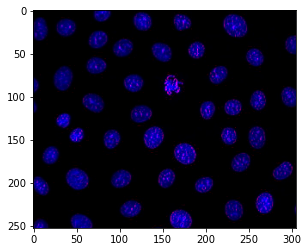

In [4]:
plt.imshow(image, cmap='gray')

In [5]:
def thresholder(image, size=1.0, background='black', channel='all'):
    '''thresholds an image with otsu method, filters noise'''
    # add median filter as an option latter
    if channel != 'all':
        image = image[...,channel]
        image = np.stack((image,)*3, axis=-1)
    image_gs = skimage.color.rgb2gray(image)
    image_blured = skimage.filters.gaussian(image_gs, sigma=size)
    threshold = skimage.filters.threshold_otsu(image_blured)
    mask =  image_blured > threshold
    if background != 'black':
        mask = np.invert(mask)
    
    # add fill holes and morphology operations
    mask = ndimage.binary_fill_holes(mask)
    return mask


In [6]:
mask = thresholder(image,channel=2)
# Next possible step is watershed or other morphological operations

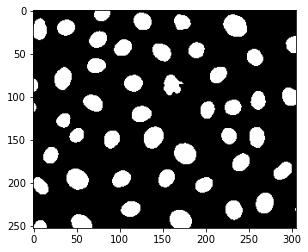

In [7]:
plt.imshow(mask, cmap='gray')

In [8]:
def detector(image, margin, constant_value=0.8):
    ''' detects particles using contours. limits bounding boxes woith the size of image'''
    contours = measure.find_contours(image, constant_value)
    bounding_boxes = []
    for contour in contours:
        #prevent values which are negative or outside the image
        neg_limiter = lambda x : 0 if x < 0 else x
        pos_limiter_x = lambda x : image.shape[0] if x > image.shape[0] else x   
        pos_limiter_y = lambda x : image.shape[1] if x > image.shape[1] else x   
        
        Ymin = neg_limiter(np.min(contour[:,0]).astype(int) - margin)
        Ymax = pos_limiter_x(np.max(contour[:,0]).astype(int) + margin)
        Xmin = neg_limiter(np.min(contour[:,1]).astype(int) - margin)
        Xmax = pos_limiter_y(np.max(contour[:,1]).astype(int) + margin)
        
        bounding_boxes.append([Ymin, Ymax, Xmin, Xmax])

    return contours, bounding_boxes

# Here can go R-CNN and UNet

In [9]:
def object_bounding_boxes(image,detector, margin=0):
    '''detects particles of a given size, returns its coordinates in a list. Accepts custom detector, image or thresholded image'''
    contours,bounding_boxes  = detector(image, margin)
    return (contours, bounding_boxes)

contours, bounding_boxes = object_bounding_boxes(mask,detector,1)

In [10]:
class CellObj:
    ''' An class for objects which contains object coordinates,bounded image and mask arrays, center coordinates etc'''   
    def __init__(self,index, box_coord, image, mask, contour, image_hash):
        self.original_image_hash = image_hash
        self.box_coord = box_coord
        # Saving cut image and mask to a dict
        self.images_dict = {}
        self.images_dict['cut_image'] = image[box_coord[0]:box_coord[1], box_coord[2]:box_coord[3], :]
        self.images_dict['mask'] = mask[box_coord[0]:box_coord[1], box_coord[2]:box_coord[3]]
        self.contour = contour
        self.measured_values = {}

    def return_center_of_box(self):
        return (np.mean(np.arange(self.box_coord[2], self.box_coord[3])),
                np.mean(np.arange(self.box_coord[0], self.box_coord[1]))
                )
    
    def return_area(self):
        return (np.sum(self.images_dict['mask']))

In [11]:
def create_cell_list(box_coord_list, image, mask, image_hash, contours = None):
    '''iterates over coordinate lists, create cell objects, store them into a list, return list of the given objects'''
    cell_obj_list = []
    for count, box_coord in enumerate(box_coord_list):
        if contours:
            contour = contours[count]
        else:
            contour = None
        cell_obj_list.append(CellObj(count, box_coord, image, mask, contour, image_hash))

    return cell_obj_list

In [12]:
def is_cell_bordering(cell_obj, image):
    '''returns True if CellObj box borders the margin of an image'''
    if (((cell_obj.box_coord[0] == 0) or (cell_obj.box_coord[2] == 0)) or 
        (cell_obj.box_coord[1] >= (image.shape[0]-1) or 
        (cell_obj.box_coord[3] >= (image.shape[1]-1)))):
        return True
    else:
        return False

In [13]:
cell_list = create_cell_list(bounding_boxes, image, mask, image_hash, contours)

86.4


<function matplotlib.pyplot.show(close=None, block=None)>

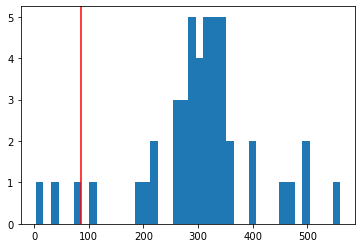

In [14]:
# Drawing histogramm and calculating values lower than 0.05 quantile for cell size filtering
# Should be in function

cell_area = []
for cell in cell_list:
    cell_area.append(cell.return_area())
plt.hist(cell_area , bins=40)
print(round(np.quantile(cell_area, 0.05),2))
plt.axvline(x=np.quantile(cell_area, 0.05), color ='red')
plt.show

In [15]:
cell_min_size = np.quantile(cell_area, 0.05)
#cell_min_size = 0
cell_list_cleared = []
for cell in cell_list:
    if (is_cell_bordering(cell, image) == False) and (cell.return_area() > cell_min_size):
        cell_list_cleared.append(cell)

In [16]:
def show_contours_and_boxes_on_image(image, cell_obj_list):
    '''from https://muthu.co/draw-bounding-box-around-contours-skimage/
    Draws a bounding box and contour if present around objects'''
    bounding_boxes = [cell.box_coord for cell in cell_obj_list]
    contours = [cell.contour for cell in cell_obj_list]
    boxed_img = np.copy(image) 
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
        
    if contours:
        for n, contour in enumerate(contours):
            ax.plot(contours[n][:, 1], contours[n][:, 0], linewidth=2)
        
    for box in bounding_boxes:
        r = [box[0],box[1],box[1],box[0], box[0]]
        c = [box[3],box[3],box[2],box[2], box[3]]
        rr, cc = polygon_perimeter(r, c, image.shape)
        boxed_img[rr, cc] = (255,255,255) #set color white
    ax.imshow(boxed_img, interpolation='nearest', cmap=plt.cm.gray)
    plt.show()

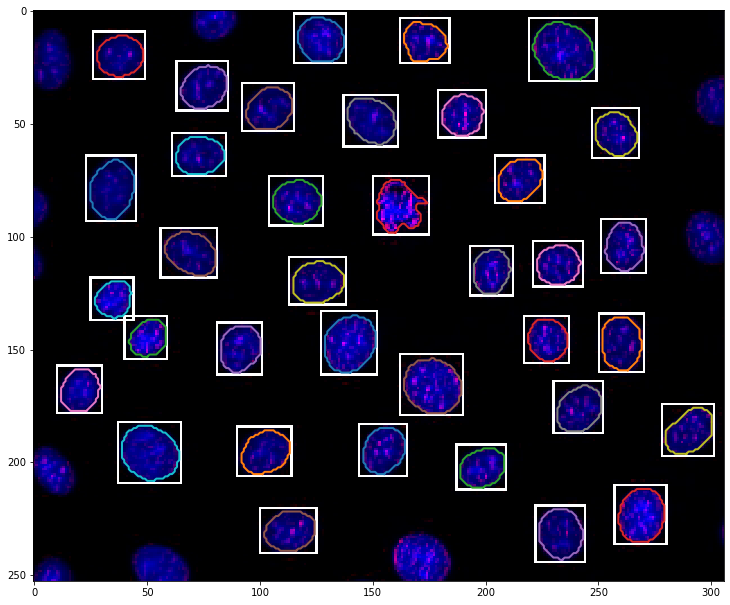

In [17]:
show_contours_and_boxes_on_image(image, cell_list_cleared)

In [18]:
def show_cell_and_mask(cell_obj):
    '''shows induvidual cell from a cell object'''
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(cell_obj.images_dict['cut_image'], interpolation='nearest', cmap=plt.cm.gray)
    ax2.imshow(cell_obj.images_dict['mask_image'], interpolation='nearest', cmap=plt.cm.gray)
    plt.show()

In [19]:
def save_objects_as_pickle(cell_list, filename):
    with open(f'cell_lists/{filename}.pickle', 'wb') as handle:
        pickle.dump(cell_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
save_objects_as_pickle(cell_list_cleared, 'cell_list')

In [21]:
def save_objects_as_tiff(cell_list, path, n_channels=3):
    # finds the biggest bounding box
    largest_box = [0, 0]
    for cell in cell_list:
        x_dim = cell.box_coord[1] - cell.box_coord[0]
        y_dim = cell.box_coord[3] - cell.box_coord[2]
        if x_dim > largest_box[0]:
            largest_box[0] = x_dim
        if y_dim > largest_box[1]:
            largest_box[1] = y_dim
    #creates an empty stack with this size
    stack = np.zeros((largest_box[0],largest_box[1]))
    #add automatic dimension increase for RGB or other nDimensions
    stack = np.stack((stack,)*n_channels, axis=-1)
    stack = np.stack((stack,), axis=0)
    #reshaping each cell array and adding to the stack
    for cell in cell_list:
        array = cell.images_dict['cut_image']
        bigger_array = np.zeros((largest_box[0],largest_box[1]))
        bigger_array.fill(255)
        bigger_array  = np.stack((bigger_array,)*n_channels, axis=-1)
        x = 0
        y = 0
        bigger_array[x:x+array.shape[0], y:y+array.shape[1]] = array
        bigger_array = np.expand_dims(bigger_array,0)
        stack = np.concatenate((stack,bigger_array),axis=0)
    tifffile.imwrite(f'processed_images/{path}.tiff', stack[1:,...], photometric='rgb')
save_objects_as_tiff(cell_list_cleared, f'{image_hash}_stack')